<a href="https://colab.research.google.com/github/shivangisachan20/Air_quality_prediction/blob/main/knowledge_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is a Knowledge Graph

A Knowledge Graph is a set of data points connected by relations that describe a domain, for instance, a business, an organization, or a field of study. It is a powerful way of representing data because Knowledge Graphs can be built automatically and can then be explored to reveal new insights about the domain.

The concept of Knowledge Graphs borrows from the Graph Theory. In this particular representation, we store data as:

![0_ntSr1qbO-9nq20JD.png](attachment:0_ntSr1qbO-9nq20JD.png)

Entity 1 and Entity 2 are called nodes and the Relationship is called an edge. Of course, in a real-world knowledge graph, there are lots of entities and relationships and there is more than one way to arrive at one entity starting from another.

Usually, these types of graphs is modeled with triples, which are sets of three items like (subject, verb, object), with the verb being the relationship between the subject and the object - for example (London, is_capital, England).

In [64]:
import spacy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [65]:
nlp = spacy.load('en_core_web_sm')

doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
    print(tok.text, "...", tok.dep_)

The ... det
22 ... nummod
- ... punct
year ... npadvmod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


In [66]:
!pip install beautifulsoup4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [68]:

# import wikipedia sentences
import pandas as pd
url = "https://raw.githubusercontent.com/phgunawan/Latihan-ML/master/wiki_sentences_v2.csv"

candidate_sentences = pd.read_csv(url)
candidate_sentences.shape

(4318, 1)

In [69]:
candidate_sentences

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."
...,...
4313,"confidencial also responded negatively, calling the film a barren drama, unsubtle and self-indulgent."
4314,and le parisien gave the film their highest five-star rating.
4315,"the museum collection includes 37,000 film titles, 60,000 posters, 700,000 photographs and 20,000 books."
4316,"its predecessor was the dutch historical film archive, founded in 1946."


In [70]:
var = candidate_sentences['sentence']

In [71]:
var[:241]

0                                           confused and frustrated, connie decides to leave on her own.
1                                                      later, a woman’s scream is heard in the distance.
2                                                               christian is then paralyzed by an elder.
3                                                                             the temple is set on fire.
4                                                                      outside, the cult wails with him.
                                                     ...                                                
236     poltergeist is ranked the 20th scariest movie ever made by the chicago film critics association.
237    the changeling is a 1980 canadian supernatural psychological horror film directed by peter medak.
238                                      its influence and inspiration can still be seen in films today.
239                         my bloody valentine  is a s

In [72]:
doc = nlp("confused and frustrated, connie decides to leave on her own.")

for tok in doc:
    print(tok.text, "...", tok.dep_)

confused ... advcl
and ... cc
frustrated ... conj
, ... punct
connie ... nsubj
decides ... ROOT
to ... aux
leave ... xcomp
on ... prep
her ... poss
own ... pobj
. ... punct


### Entity Pairs Extraction

To build a knowledge graph, the most important things are the nodes and the edges between them.

In [73]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

                ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [74]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [ ]:
entity_pairs = []

for i in tqdm(var[:241]):
    entity_pairs.append(get_entities(i))

In [76]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m', 'international sales rights'],
 ['musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', '-']]

### Relation / Predicate Extraction


In [77]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1",[pattern]) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [78]:
get_relation("John completed the task")


'completed'

In [79]:
get_relation("beautiful house on the left")

'house on'

In [80]:
relations = [get_relation(i) for i in tqdm(var[:241])]







  0%|          | 0/241 [00:00<?, ?it/s]





  4%|▍         | 10/241 [00:00<00:02, 99.66it/s]





  9%|▊         | 21/241 [00:00<00:02, 99.40it/s]





 13%|█▎        | 31/241 [00:00<00:02, 91.52it/s]





 17%|█▋        | 41/241 [00:00<00:02, 92.92it/s]





 21%|██        | 51/241 [00:00<00:02, 91.75it/s]





 25%|██▌       | 61/241 [00:00<00:02, 87.68it/s]





 29%|██▉       | 70/241 [00:00<00:01, 87.21it/s]





 33%|███▎      | 79/241 [00:00<00:01, 85.97it/s]





 37%|███▋      | 90/241 [00:00<00:01, 92.02it/s]





 43%|████▎     | 103/241 [00:01<00:01, 101.10it/s]





 48%|████▊     | 115/241 [00:01<00:01, 105.13it/s]





 52%|█████▏    | 126/241 [00:01<00:01, 104.88it/s]





 57%|█████▋    | 138/241 [00:01<00:00, 108.84it/s]





 62%|██████▏   | 149/241 [00:01<00:00, 108.01it/s]





 67%|██████▋   | 162/241 [00:01<00:00, 112.26it/s]





 72%|███████▏  | 174/241 [00:01<00:00, 112.42it/s]





 78%|███████▊  | 187/241 [00:01<00:00, 116.93it/s]





 83%|████████▎ 

In [81]:
pd.Series(relations).value_counts()[:50]


is                 19
was                13
released            8
scheduled           6
include             5
expected            4
revealed            3
announced at        2
occurred            2
hired               2
brought             2
drafted by          2
wonder              2
cast in             2
begun by early      2
through             2
introduced in       2
began in            2
announced in        2
affleck as          2
confirmed as        2
began on            2
reported to         2
presented in        2
was in              2
wait                2
did                 2
became              2
gives               2
joined              2
's                  2
received by         2
become              2
considered          1
released in         1
shouts              1
came                1
part                1
returned            1
had                 1
been supportive     1
expressed real      1
appointed           1
used                1
overlap with        1
went      

### Build a Knowledge Graph


In [82]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,connie,own,decides
1,later scream,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,outside cult,him,wails with
...,...,...,...
236,poltergeist,ever film critics association,ranked
237,changeling,psychological peter medak,is
238,influence,still films,seen in
239,bloody valentine,day fiction,is


In [83]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

  0%|          | 0/4318 [12:30<?, ?it/s]


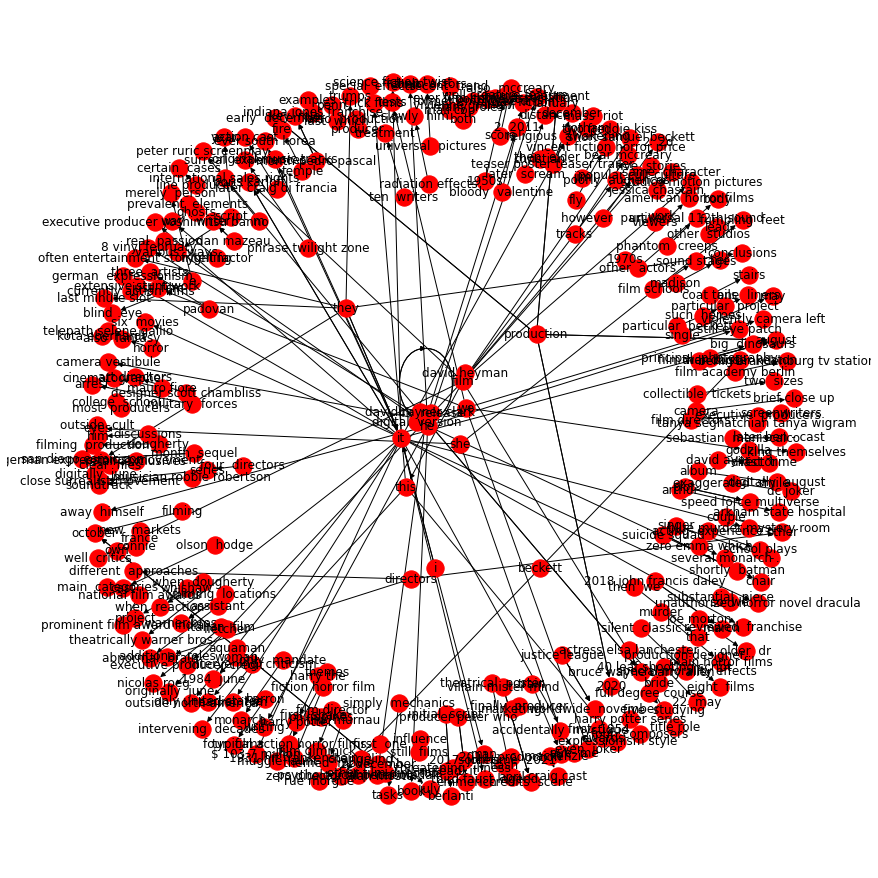

In [84]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Well, this is not exactly what we were hoping for (still looks quite a sight though!).

It turns out that we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates.

So, it’s advisable to use only a few important relations to visualize a graph. I will take one relation at a time. Let’s start with the relation “composed by”:

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight='bold')
plt.show()

Since writing is an important role in any movie, I would like to visualize the graph for the “written by” relation:



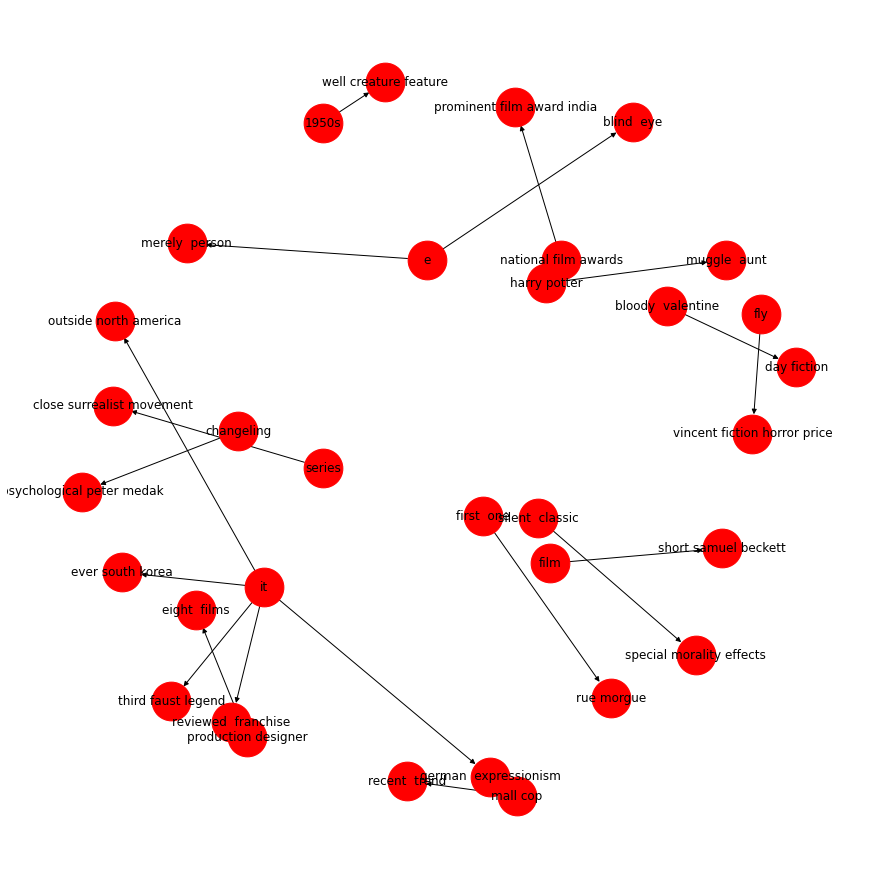

In [89]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="is"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Let’s see the knowledge graph of another important predicate, i.e., the “released in”:



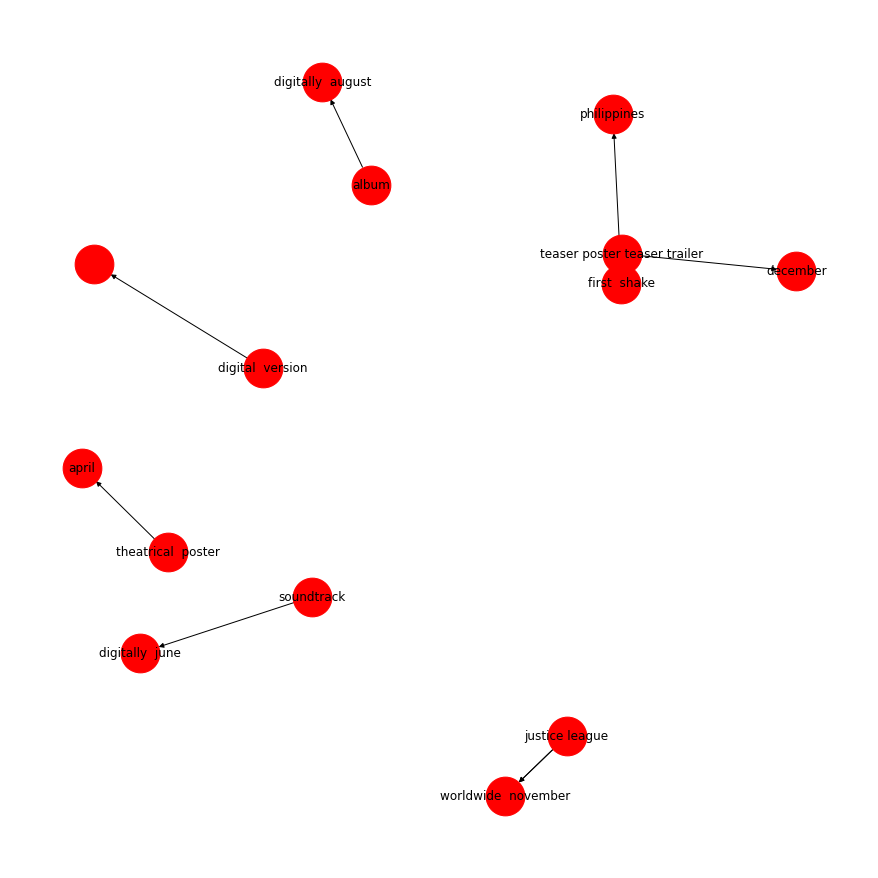

In [90]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()